In [1]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import shapely as shp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

# 1) Get the EFFIS fires for each of the regions

In [2]:
# Files from EFFIS
mediterrarean_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\EFFIS\mediterranean\EFFIS_BurntAreas_2008-2023_medCountries_greater10ha.shp"
central_europe_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\ML-data-Central-Europe-gridded\historical_ignition\original\EFFIS_Burned_Areas_2008-2023_greater10ha_original.shp"
north_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\ML-data-Northern-Europe-gridded\historical_ignition\original\EFFIS_Burned_Areas_2008-2023_greater10ha_original.shp"

# Load the files
EFFIS_south  = gpd.read_file(mediterrarean_file)
EFFIS_centr = gpd.read_file(central_europe_file)
EFFIS_north = gpd.read_file(north_file)

#change teh EPSG to make good areas calcu
common_crs = "EPSG:4326"  # WGS 84
EFFIS_south = EFFIS_south.to_crs(common_crs)
EFFIS_centr = EFFIS_centr.to_crs(common_crs)
EFFIS_north = EFFIS_north.to_crs(common_crs)

# creare a column called year and save it together with area_ha
EFFIS_south['initialdat'] = pd.to_datetime(EFFIS_south['initialdat'])
EFFIS_south['year'] = EFFIS_south['initialdat'].dt.year
EFFIS_south = EFFIS_south[(EFFIS_south['year'] >= 2008) & (EFFIS_south['year'] <= 2019)]
EFFIS_south = EFFIS_south[['year', 'area_ha']]

EFFIS_centr['initialdat'] = pd.to_datetime(EFFIS_centr['initialdat'])
EFFIS_centr['year'] = EFFIS_centr['initialdat'].dt.year
EFFIS_centr = EFFIS_centr[(EFFIS_centr['year'] >= 2008) & (EFFIS_centr['year'] <= 2019)]
EFFIS_centr = EFFIS_centr[['year', 'area_ha']]

EFFIS_north['initialdat'] = pd.to_datetime(EFFIS_north['initialdat'])
EFFIS_north['year'] = EFFIS_north['initialdat'].dt.year
EFFIS_north = EFFIS_north[(EFFIS_north['year'] >= 2008) & (EFFIS_north['year'] <= 2019)]
EFFIS_north = EFFIS_north[['year', 'area_ha']]


# 2) Load the ERA5 ForeFire runs

In [3]:
# Files from simulation
ForeFire_south_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\IIASA-results\South\era5-land_2008-2019\ForeFireSim_burned_area_era5-land_2008-2019_South.shp"
ForeFire_centr_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\IIASA-results\Central\era5-land_2008-2019\ForeFireSim_burned_area_era5-land_2008-2019_Central.shp"
ForeFire_North_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\IIASA-results\North\era5-land_2008-2019\ForeFireSim_burned_area_era5-land_2008-2019_North.shp"


# Load the files
ForeFire_south  = gpd.read_file(ForeFire_south_file)
ForeFire_centr = gpd.read_file(ForeFire_centr_file)
ForeFire_north = gpd.read_file(ForeFire_North_file)

# add year and store year and area_ha
ForeFire_south['date'] = pd.to_datetime(ForeFire_south['date'])
ForeFire_south['year'] = ForeFire_south['date'].dt.year
ForeFire_south = ForeFire_south[['year', 'area_ha']]

ForeFire_centr['date'] = pd.to_datetime(ForeFire_centr['date'])
ForeFire_centr['year'] = ForeFire_centr['date'].dt.year
ForeFire_centr = ForeFire_centr[['year', 'area_ha']]


ForeFire_north['date'] = pd.to_datetime(ForeFire_north['date'])
ForeFire_north['year'] = ForeFire_north['date'].dt.year
ForeFire_north = ForeFire_north[['year', 'area_ha']]

In [4]:
# Add source and region labels

# FOREFIRE ------------------------------
ForeFire_south['source'] = 'ForeFire'
ForeFire_south['region'] = 'South'

ForeFire_centr['source'] = 'ForeFire'
ForeFire_centr['region'] = 'Central'

ForeFire_north['source'] = 'ForeFire'
ForeFire_north['region'] = 'North'

# Combine the dataframes based on the 'source'


# EFFIS ------------------------------
EFFIS_south['source'] = 'EFFIS'
EFFIS_south['region'] = 'South'

EFFIS_centr['source'] = 'EFFIS'
EFFIS_centr['region'] = 'Central'

EFFIS_north['source'] = 'EFFIS'
EFFIS_north['region'] = 'North'


# Combine all dataframes into one
all_fires = pd.concat([ForeFire_south, ForeFire_centr, ForeFire_north, EFFIS_south, EFFIS_centr, EFFIS_north], ignore_index=True) 


In [5]:
ForeFire_south

,year,area_ha,source,region
0,2011,1328.96,ForeFire,South
1,2017,655.11,ForeFire,South
2,2011,113.50,ForeFire,South
3,2011,61.02,ForeFire,South
4,2013,2.26,ForeFire,South
...,...,...,...,...
8296,2017,152.95,ForeFire,South
8297,2016,2.15,ForeFire,South
8298,2009,570.58,ForeFire,South
8299,2008,1151.98,ForeFire,South


# OVER-ALL EUROPE Plot

In [6]:
# Sum the burned area for each year and source
burned_area = all_fires.groupby(['year', 'source'])['area_ha'].sum().reset_index()
burned_area['area_km2'] = burned_area['area_ha'] / 100  # Convert to km²
burned_area

,year,source,area_ha,area_km2
0,2008,EFFIS,119682.00,1196.8200
1,2008,ForeFire,396148.98,3961.4898
2,2009,EFFIS,282959.00,2829.5900
3,2009,ForeFire,383838.07,3838.3807
4,2010,EFFIS,205688.00,2056.8800
5,2010,ForeFire,242268.89,2422.6889
6,2011,EFFIS,361369.00,3613.6900
7,2011,ForeFire,541453.00,5414.5300
8,2012,EFFIS,619571.00,6195.7100
9,2012,ForeFire,781402.47,7814.0247


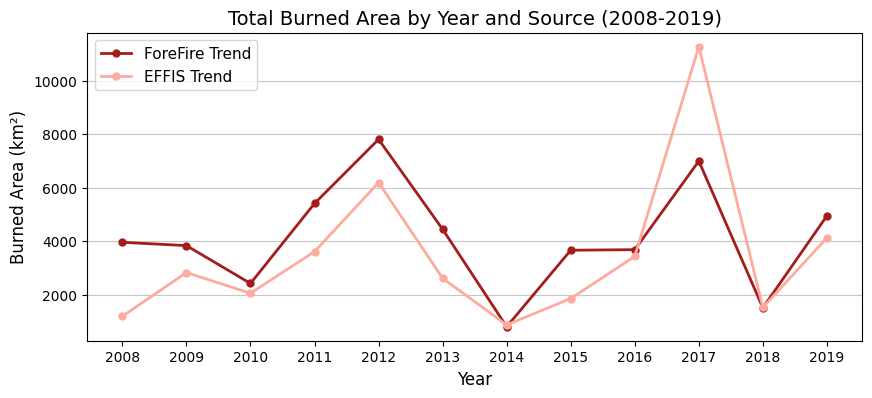

In [31]:
total_EFFIS = burned_area[burned_area['source'] == 'EFFIS']
total_ForeFire = burned_area[burned_area['source'] == 'ForeFire']
years = np.sort(total_EFFIS['year'].unique())

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 4))


#line plot to see the trend
ax.plot(total_ForeFire['year'], total_ForeFire['area_km2'], color='#A31D1D', marker='o', linestyle='-', linewidth=2, markersize=5, label='ForeFire Trend')
ax.plot(total_EFFIS['year'], total_EFFIS['area_km2'], color='#FDAB9E', marker='o', linestyle='-', linewidth=2, markersize=5, label='EFFIS Trend')


# Set labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Burned Area (km²)', fontsize=12)
ax.set_title('Total Burned Area by Year and Source (2008-2019)', fontsize=14)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.legend(loc='upper left', fontsize=11)
# Show grid
ax.grid(axis='y', alpha=0.7)
# Adjust layout
# plt.tight_layout()
plt.show()


In [8]:
burned_area_region = all_fires.groupby(['year', 'source', 'region'])['area_ha'].sum().reset_index()
burned_area_region['area_km2'] = burned_area_region['area_ha'] / 100  # Convert to km²


south = burned_area_region[burned_area_region['region'] == 'South']
central = burned_area_region[burned_area_region['region'] == 'Central']
north = burned_area_region[burned_area_region['region'] == 'North']

# NORTH

In [9]:
# Select the data for the regions source
north_EFFIS = north[north['source'] == 'EFFIS']
north_ForeFire = north[north['source'] == 'ForeFire']


In [10]:
# Group by year and sum area
north_ForeFire_yearly = north_ForeFire.groupby('year')['area_ha'].sum().reset_index()
north_ForeFire_yearly['area_km2'] = north_ForeFire_yearly['area_ha'] / 100

# Define full year range
full_years = pd.DataFrame({'year': range(2008, 2020)})

# Merge to fill missing years with 0
north_ForeFire_complete = pd.merge(full_years, north_ForeFire_yearly, on='year', how='left')
north_ForeFire_complete['area_ha'] = north_ForeFire_complete['area_ha'].fillna(0)
north_ForeFire_complete['area_km2'] = north_ForeFire_complete['area_km2'].fillna(0)

# Add source and region info
north_ForeFire_complete['source'] = 'ForeFire'
north_ForeFire_complete['region'] = 'North'

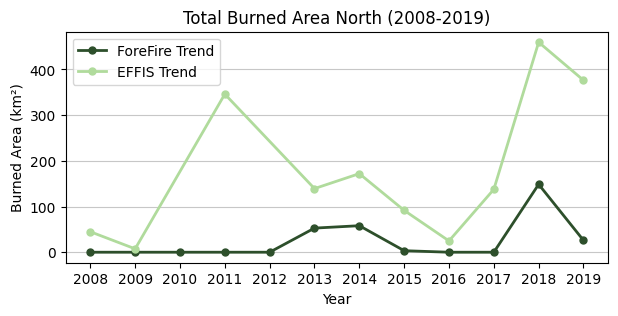

In [ ]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 3))


#line plot to see the trend
ax.plot(north_ForeFire_complete['year'], north_ForeFire_complete['area_km2'], color='#2D4F2B', marker='o', linestyle='-', linewidth=2, markersize=5, label='ForeFire Trend')
ax.plot(north_EFFIS['year'], north_EFFIS['area_km2'], color='#B0DB9C', marker='o', linestyle='-', linewidth=2, markersize=5, label='EFFIS Trend')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Burned Area (km²)')
ax.set_title('Total Burned Area North (2008-2019)')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.legend(loc='upper left')
# Show grid
ax.grid(axis='y', alpha=0.7)
# Adjust layout
# plt.tight_layout()
plt.show()


# Central

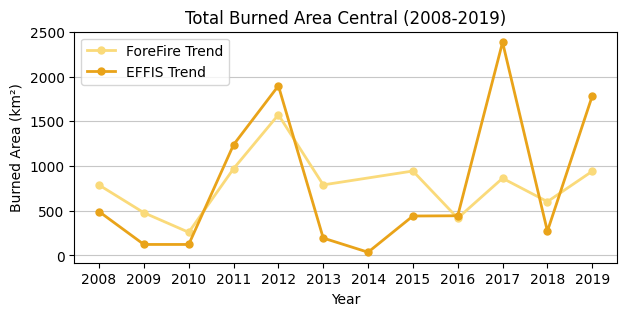

In [12]:
# Select the data for the regions source
central_EFFIS = central[central['source'] == 'EFFIS']
central_ForeFire = central[central['source'] == 'ForeFire']


# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 3))


#line plot to see the trend
ax.plot(central_ForeFire['year'], central_ForeFire['area_km2'], color='#FADA7A', marker='o', linestyle='-', linewidth=2, markersize=5, label='ForeFire Trend')
ax.plot(central_EFFIS['year'], central_EFFIS['area_km2'], color='#E9A319', marker='o', linestyle='-', linewidth=2, markersize=5, label='EFFIS Trend')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Burned Area (km²)')
ax.set_title('Total Burned Area Central (2008-2019)')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.legend(loc='upper left')
# Show grid
ax.grid(axis='y', alpha=0.7)
# Adjust layout
# plt.tight_layout()
plt.show()


# South

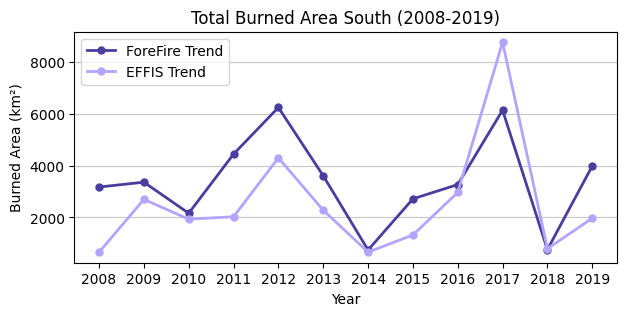

In [13]:
# Select the data for the regions source
south_EFFIS = south[south['source'] == 'EFFIS']
south_ForeFire = south[south['source'] == 'ForeFire']


# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 3))


#line plot to see the trend
ax.plot(south_ForeFire['year'], south_ForeFire['area_km2'], color='#493D9E', marker='o', linestyle='-', linewidth=2, markersize=5, label='ForeFire Trend')
ax.plot(south_EFFIS['year'], south_EFFIS['area_km2'], color='#B2A5FF', marker='o', linestyle='-', linewidth=2, markersize=5, label='EFFIS Trend')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Burned Area (km²)')
ax.set_title('Total Burned Area South (2008-2019)')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.legend(loc='upper left')
# Show grid
ax.grid(axis='y', alpha=0.7)
# Adjust layout
# plt.tight_layout()
plt.show()
